# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [3]:
QUANTILES = np.linspace(0, 1, 10000)
display(QUANTILES[:10])
display(QUANTILES[-10:])

array([0.        , 0.00010001, 0.00020002, 0.00030003, 0.00040004,
       0.00050005, 0.00060006, 0.00070007, 0.00080008, 0.00090009])

array([0.99909991, 0.99919992, 0.99929993, 0.99939994, 0.99949995,
       0.99959996, 0.99969997, 0.99979998, 0.99989999, 1.        ])

In [4]:
BASE_FOLDER = Path("..", "base").resolve()
# BASE_FOLDER = Path("base").resolve()

assert BASE_FOLDER.exists()

display(BASE_FOLDER)

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_gene_modules/base')

In [5]:
OUTPUT_DIR_CM = Path(BASE_FOLDER, "results", "clustermatch", "enrichPathway").resolve()
display(OUTPUT_DIR_CM)
assert OUTPUT_DIR_CM.exists()

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_gene_modules/base/results/clustermatch/enrichPathway')

In [6]:
OUTPUT_DIR_PE = Path(BASE_FOLDER, "results", "pearson", "enrichPathway").resolve()
display(OUTPUT_DIR_PE)
assert OUTPUT_DIR_PE.exists()

PosixPath('/home/miltondp/projects/labs/greenelab/clustermatch_gene_modules/base/results/pearson/enrichPathway')

# Load enrichment results

In [7]:
all_files = list(OUTPUT_DIR_CM.glob("*.pkl")) + list(OUTPUT_DIR_PE.glob("*.pkl"))

In [8]:
display(len(all_files))
# assert len(all_files) == int(2 * 126)

14

In [9]:
all_results = []

for f_full in all_files:
    #     print(f)

    f = f_full.name

    fsplit = str(f).split("-")
    k = int(fsplit[0].split("_")[1])
    method = fsplit[1]
    gene_sets = fsplit[2]
    results_type = fsplit[3].split(".")[0]

    data = pd.read_pickle(f_full)

    data = data.assign(
        **{
            "k": k,
            "method": method,
            "gene_sets": gene_sets,
            "results_type": results_type,
        }
    )

    data["Cluster"] = data["Cluster"].astype("category")
    data["k"] = data["k"].astype("category")
    data["method"] = data["method"].astype("category")
    data["gene_sets"] = data["gene_sets"].astype("category")
    data["results_type"] = data["results_type"].astype("category")

    all_results.append(data)

In [10]:
len(all_results)

14

In [11]:
all_results_df = pd.concat(all_results, ignore_index=True)

In [12]:
all_results_df.shape

(10699, 14)

In [13]:
all_results_df.head()

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,k,method,gene_sets,results_type
0,C23,R-HSA-156842,Eukaryotic Translation Elongation,48/51,93/10654,1.056902e-101,3.783709e-99,3.571216e-99,RPL10/RPL13A/RPS11/EEF1A1/RPLP2/RPLP1/RPL19/RP...,48,30,clustermatch,enrichPathway,full
1,C23,R-HSA-156902,Peptide chain elongation,47/51,89/10654,1.629540e-99,2.916877e-97,2.753065e-97,RPL10/RPL13A/RPS11/EEF1A1/RPLP2/RPLP1/RPL19/RP...,47,30,clustermatch,enrichPathway,full
2,C23,R-HSA-192823,Viral mRNA Translation,46/51,89/10654,3.762476e-96,4.489888e-94,4.237736e-94,RPL10/RPL13A/RPS11/RPLP2/RPLP1/RPL19/RPS2/RPL3...,46,30,clustermatch,enrichPathway,full
3,C23,R-HSA-2408557,Selenocysteine synthesis,46/51,93/10654,6.147558e-95,4.401652e-93,4.154455e-93,RPL10/RPL13A/RPS11/RPLP2/RPLP1/RPL19/RPS2/RPL3...,46,30,clustermatch,enrichPathway,full
4,C23,R-HSA-72764,Eukaryotic Translation Termination,46/51,93/10654,6.147558e-95,4.401652e-93,4.154455e-93,RPL10/RPL13A/RPS11/RPLP2/RPLP1/RPL19/RPS2/RPL3...,46,30,clustermatch,enrichPathway,full


In [14]:
assert all_results_df["results_type"].unique().shape[0] == 1

# QQ-plot of $p$-values

In [15]:
_df_common = all_results_df  # [all_results_df["results_type"] == "full"]
_clustermatch_values = _df_common[_df_common["method"] == "clustermatch"]["p.adjust"]
_pearson_values = _df_common[_df_common["method"] == "pearson"]["p.adjust"]

In [16]:
# quantiles_df = pd.DataFrame(
#     {
#         "clustermatch": -np.log10(_clustermatch_values.quantile(QUANTILES)),
#         "pearson": -np.log10(_pearson_values.quantile(QUANTILES)),
#     }
# )

In [17]:
quantiles_df = pd.DataFrame(
    {
        "clustermatch": pd.Series(-np.log10(_clustermatch_values)).quantile(QUANTILES),
        "pearson": pd.Series(-np.log10(_pearson_values)).quantile(QUANTILES),
    }
)

In [18]:
quantiles_df.shape

(10000, 2)

In [19]:
quantiles_df.head()

,clustermatch,pearson
0.0000,1.301039,1.301542
0.0001,1.301166,1.301812
0.0002,1.301236,1.302082
0.0003,1.301236,1.302251
0.0004,1.301248,1.302363


Text(0.5, 1.0, 'Reactome')

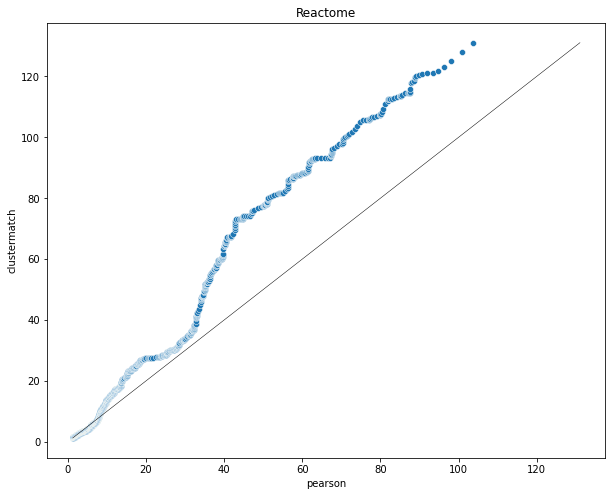

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    data=quantiles_df,
    x="pearson",
    y="clustermatch",
    ax=ax,
)

# ax.set_xlabel(None)
# ax.set_ylabel(None)

min_val = min((quantiles_df.iloc[:, 0].min(), quantiles_df.iloc[:, 1].min()))
max_val = max((quantiles_df.iloc[:, 0].max(), quantiles_df.iloc[:, 1].max()))
ax.plot([min_val, max_val], [min_val, max_val], "k", linewidth=0.5)

ax.set_title("Reactome")

# plt.legend()

# Plot unique Reactome terms

In [21]:
plot_df = (
    all_results_df.groupby(["method", "k", "results_type"])["ID"]
    .nunique()
    .rename("count")
    .reset_index()
)

In [22]:
plot_df.shape

(16, 4)

In [23]:
plot_df.head()

,method,k,results_type,count
0,clustermatch,2,full,495
1,clustermatch,5,full,438
2,clustermatch,10,full,502
3,clustermatch,15,full,549
4,clustermatch,20,full,465


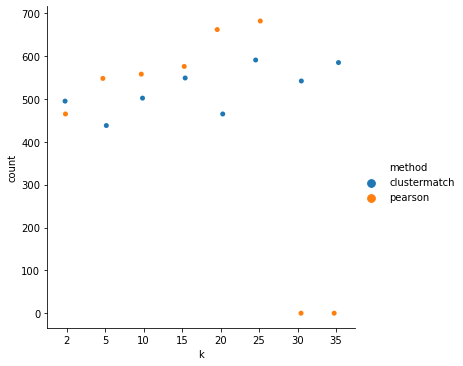

In [24]:
# fig, ax = plt.subplots(figsize=(10, 8))

sns.catplot(
    data=plot_df,
    x="k",
    y="count",
    hue="method",
    #     ax=ax,
)

# ax.set_xlabel(None)
# ax.set_ylabel(None)

# min_val = min((quantiles_df.iloc[:, 0].min(), quantiles_df.iloc[:, 1].min()))
# max_val = max((quantiles_df.iloc[:, 0].max(), quantiles_df.iloc[:, 1].max()))
# ax.plot([min_val, max_val], [min_val, max_val], "k", linewidth=0.5)

# plt.legend()

# Intersection of terms

In [262]:
from upsetplot import UpSet

In [263]:
UpSet?

Init signature:
UpSet(
    data,
    orientation='horizontal',
    sort_by='degree',
    sort_categories_by='cardinality',
    subset_size='auto',
    sum_over=None,
    facecolor='black',
    with_lines=True,
    element_size=32,
    intersection_plot_elements=6,
    totals_plot_elements=2,
    show_counts='',
    show_percentages=False,
)
Docstring:     
Manage the data and drawing for a basic UpSet plot

Primary public method is :meth:`plot`.

Parameters
----------
data : pandas.Series or pandas.DataFrame
    Elements associated with categories (a DataFrame), or the size of each
    subset of categories (a Series).
    Should have MultiIndex where each level is binary,
    corresponding to category membership.
    If a DataFrame, `sum_over` must be a string or False.
orientation : {'horizontal' (default), 'vertical'}
    If horizontal, intersections are listed from left to right.
sort_by : {'cardinality', 'degree'}
    If 'cardinality', subset are listed from largest to smallest.
  

In [260]:
_df_common = all_results_df[(all_results_df["results_type"] == "simplified")]

In [264]:
plot_df = pd.DataFrame(
    {
        "clustermatch": _df_common["method"] == "clustermatch",
        "clustermatch": _df_common["method"] == "pearson",
    }
)

In [265]:
plot_df

,clustermatch
13126,True
13127,True
13128,True
13129,True
13130,True
...,...
292986,False
292987,False
292988,False
292989,False


In [116]:
plot_df.unstack()

ont,BP,CC,MF
method,,,
clustermatch,99546,21239,17570
pearson,116843,18777,19907


In [114]:
plot(plot_df)

ValueError: The DataFrame has values in its index that are not boolean

In [109]:
df = all_results_df[all_results_df["results_type"] == "full"][["method", "ont"]]

In [103]:
df.shape

(258627, 2)

In [104]:
df.head()

,method,ont
0,clustermatch,BP
1,clustermatch,BP
2,clustermatch,BP
3,clustermatch,BP
4,clustermatch,BP
